<a href="https://colab.research.google.com/github/amin1nasim/TAing601_Computer_Vision/blob/main/Week6/Why_ConvNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why do we need ConvNets?
Let's quickly create a fully connected network and train it on MNIST dataset again so we can address shortcomings of fully connected networks MLPs and benefits of ConvNets.

In [84]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import matplotlib.pyplot as plt

In [85]:
# Downloading the Dataset
download = not os.path.exists('./dataset/MNIST/')
transform = transforms.Compose([transforms.ToTensor()])
train_dataset  = datasets.MNIST('./dataset/MNIST/',
                                train=True,
                                download=download,
                                transform=transform)

test_dataset = datasets.MNIST('./dataset/MNIST/',
                              train=False,
                              download=download,
                              transform=transform)

In [86]:
# Creating train and val portions
train_dataset, validation_dataset = random_split(train_dataset, [50000, 10000], generator=torch.Generator().manual_seed(999))

In [87]:
# Using Dataloader to make mini-batches
phases = {
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
    }
loader = {
    phase: DataLoader(ds, batch_size=64, shuffle=(phase=='train'))
    for phase, ds in phases.items()
}

In [104]:
# The model architecture
inplace = False
CreateSequentialModel = lambda : nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256, bias=True),
    nn.ReLU(inplace=inplace),
    nn.Dropout(p=0.2, inplace=inplace),

    nn.Linear(256, 128, bias=True),
    nn.ReLU(inplace=inplace),
    nn.Dropout(p=0.2, inplace=inplace),

    nn.Linear(128, 64, bias=True),
    nn.ReLU(inplace=inplace),
    nn.Dropout(p=0.2, inplace=inplace),

    nn.Linear(64, 32, bias=True),
    nn.ReLU(inplace=inplace),
    nn.Dropout(p=0.2, inplace=inplace),

    nn.Linear(32, 10)
)

model = CreateSequentialModel()

In [105]:
print(f'number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

number of parameters: 244522


In [89]:
# Train and validation helpers
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(model, loader=loader, criterion=criterion, mode='validation', device=device):
    state = model.training
    model.eval()
    total_correct = 0
    total_loss = 0
    total = 0
    for i, (images, labels) in enumerate(loader[mode]):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        total += images.size(0)
        _, predictions = outputs.max(1)
        total_correct += (labels == predictions).sum()
    loss = total_loss / total
    accuracy = total_correct / total
    model.training = state
    print(f'{mode} Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')

In [90]:
# Main train loop for 10 epochs
model.to(device).train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 10
for epoch in range(epochs):
    total = 0
    total_correct = 0
    total_loss = 0
    for images, labels in loader['train']:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total += images.size(0)
        _, predictions = outputs.max(1)
        total_correct += (predictions == labels).sum()
        total_loss += loss.item() * images.size(0)
    accuracy = total_correct / total
    loss = total_loss / total
    print(f'Train epoch {epoch}: Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')
    evaluate(model)

Train epoch 0: Loss(1.3655) Accuracy (0.5201)
validation Loss(0.3790) Accuracy (0.8917)
Train epoch 1: Loss(0.2241) Accuracy (0.9357)
validation Loss(0.1630) Accuracy (0.9546)
Train epoch 2: Loss(0.1272) Accuracy (0.9620)
validation Loss(0.1272) Accuracy (0.9601)
Train epoch 3: Loss(0.0879) Accuracy (0.9734)
validation Loss(0.1087) Accuracy (0.9687)
Train epoch 4: Loss(0.0670) Accuracy (0.9791)
validation Loss(0.1021) Accuracy (0.9705)
Train epoch 5: Loss(0.0526) Accuracy (0.9834)
validation Loss(0.0986) Accuracy (0.9728)
Train epoch 6: Loss(0.0411) Accuracy (0.9872)
validation Loss(0.0995) Accuracy (0.9727)
Train epoch 7: Loss(0.0318) Accuracy (0.9898)
validation Loss(0.1074) Accuracy (0.9715)
Train epoch 8: Loss(0.0261) Accuracy (0.9917)
validation Loss(0.1007) Accuracy (0.9749)
Train epoch 9: Loss(0.0234) Accuracy (0.9924)
validation Loss(0.0999) Accuracy (0.9746)


In [91]:
# Finally, accuracy on test dataset
evaluate(model, mode='test')

test Loss(0.0953) Accuracy (0.9757)


#Shifted data
Now let's see what happens if we shift our dataset by few pixels.

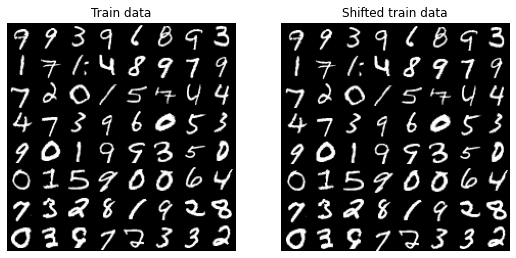

In [92]:
figure = plt.figure(figsize=(9, 9))

batch_of_train_images = next(iter(loader['train']))[0]
figure.add_subplot(1, 2, 1)
plt.imshow(utils.make_grid(batch_of_train_images, padding=0).permute(1, 2, 0))
plt.title('Train data')
plt.axis(False)

shifted = transforms.functional.affine(batch_of_train_images, angle=0., translate=[1, 1], scale=1., shear=1.)
figure.add_subplot(1, 2, 2)
plt.imshow(utils.make_grid(shifted, padding=0).permute(1, 2, 0))
plt.title('Shifted train data')
plt.axis(False)

figure.show()

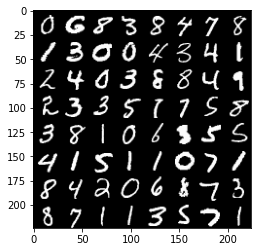

tensor([0, 6, 8, 3, 8, 4, 7, 8, 1, 3, 0, 0, 4, 3, 4, 1, 2, 4, 0, 3, 8, 8, 4, 9,
        2, 3, 3, 5, 1, 7, 5, 8, 3, 8, 1, 0, 6, 3, 5, 5, 4, 1, 5, 1, 1, 0, 7, 1,
        8, 4, 2, 0, 6, 8, 7, 3, 8, 7, 1, 1, 3, 5, 7, 1])


In [93]:
shift_transform = lambda img: transforms.functional.affine(img,
                                                           angle=0.,
                                                           translate=[1, 1],
                                                           scale=1.,
                                                           shear=1.)

shifted_train_dataset = [(shift_transform(img), label) for img, label in loader['train']]

# Double check
plt.imshow(utils.make_grid(shifted_train_dataset[0][0], padding=0).permute(1, 2, 0))
plt.show()
print(shifted_train_dataset[0][1])

In [94]:
state = model.training
model.eval()
total_correct = 0
total_loss = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(shifted_train_dataset):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        total += images.size(0)
        _, predictions = outputs.max(1)
        total_correct += (labels == predictions).sum()
loss = total_loss / total
accuracy = total_correct / total
model.training = state
print(f'Shifted_train_dataset Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')

Shifted_train_dataset Loss(0.4084) Accuracy (0.9111)


In [191]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.activation import ReLU
ConvNetModel = lambda : nn.Sequential(
    # Convolution Part
    nn.Conv2d(1, 64, 3, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Conv2d(64, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),

    nn.Conv2d(64, 10, 1),

    nn.Flatten(),
    # We might see FC at this point as well
)
model = ConvNetModel().to(device)

In [192]:
model(images).shape

torch.Size([64, 10])

### Fewer parameters

In [193]:
print(f'number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

number of parameters: 112074


In [194]:
# Main train loop for 10 epochs
model.to(device).train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
epochs = 10
for epoch in range(epochs):
    total = 0
    total_correct = 0
    total_loss = 0
    for images, labels in loader['train']:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total += images.size(0)
        _, predictions = outputs.max(1)
        total_correct += (predictions == labels).sum()
        total_loss += loss.item() * images.size(0)
    accuracy = total_correct / total
    loss = total_loss / total
    print(f'Train epoch {epoch}: Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')
    evaluate(model)

Train epoch 0: Loss(0.7228) Accuracy (0.7645)
validation Loss(0.1226) Accuracy (0.9623)
Train epoch 1: Loss(0.1076) Accuracy (0.9671)
validation Loss(0.0935) Accuracy (0.9708)
Train epoch 2: Loss(0.0723) Accuracy (0.9769)
validation Loss(0.0706) Accuracy (0.9780)
Train epoch 3: Loss(0.0561) Accuracy (0.9824)
validation Loss(0.0916) Accuracy (0.9687)
Train epoch 4: Loss(0.0464) Accuracy (0.9854)
validation Loss(0.0522) Accuracy (0.9835)
Train epoch 5: Loss(0.0392) Accuracy (0.9878)
validation Loss(0.0621) Accuracy (0.9803)
Train epoch 6: Loss(0.0347) Accuracy (0.9890)
validation Loss(0.0393) Accuracy (0.9864)
Train epoch 7: Loss(0.0295) Accuracy (0.9906)
validation Loss(0.0519) Accuracy (0.9839)
Train epoch 8: Loss(0.0272) Accuracy (0.9911)
validation Loss(0.0430) Accuracy (0.9857)
Train epoch 9: Loss(0.0226) Accuracy (0.9931)
validation Loss(0.0463) Accuracy (0.9866)


### Better Test Accuracy

In [195]:
# Finally, accuracy on test dataset
evaluate(model, mode='test')

test Loss(0.0323) Accuracy (0.9896)


So far, ConvNet got us better accuracy with test dataset. Hooray!!!

Now let's try it with shifted data.

### More robust to shift

In [196]:
state = model.training
model.eval()
total_correct = 0
total_loss = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(shifted_train_dataset):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        total += images.size(0)
        _, predictions = outputs.max(1)
        total_correct += (labels == predictions).sum()
loss = total_loss / total
accuracy = total_correct / total
model.training = state
print(f'Shifted_train_dataset Loss({loss:6.4f}) Accuracy ({accuracy:6.4f})')

Shifted_train_dataset Loss(0.0840) Accuracy (0.9748)


# Summary
Convolutional networks are very popular in the field of computer vision. Some benefits of ConvNets are as follow,

1. Parameter efficiency: In FCNs, each neuron is connected to every neuron in the previous layer, resulting in a large number of parameters. In contrast, CNNs use shared weights and biases for each convolutional filter, reducing the number of parameters and allowing for more efficient training.

2. Translation invariance: CNNs are designed to be translation invariant, meaning that they can recognize objects regardless of their location in the image. This is achieved by using convolutional layers, which scan the image with a set of filters to extract features.

3. Feature hierarchies: CNNs can automatically learn hierarchical representations of features, with each layer of the network building on the previous layer. This allows the network to learn more complex features and patterns in the data.

4. Robustness to local variations: In many computer vision tasks, objects of interest may have variations in shape, size, or orientation. CNNs are able to handle these variations by using pooling layers to downsample the feature maps and reduce the impact of local variations.
